In [1]:
import numpy as np

import sys
sys.path.append("..")
from nc_suite import *

In [2]:
# Create img and labels
from torchvision import datasets
import cv2

img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (28,28))

mnist = datasets.MNIST('data', train=True, download=True)
img = np.asarray(mnist[2][0])

label = np.copy(img) # shallow copy is fine, since it isn't python objects inside
label[label>0] = 1

In [3]:
# Really simple weighting methods...
# based on nc-test-multi these are the only consistent ones :)
# see TODO in nc-test-multi

# Image 1 (MNIST)
i_W = intensity_weight_matrix(img)
pi_W = intens_posit_wm(img)

# Image 2 (baby)
i_W_baby = intensity_weight_matrix(img_baby)
pi_W_baby = intens_posit_wm(img_baby)

In [4]:
from collections import OrderedDict

weights = OrderedDict(
    img=img, label=label, i_W=i_W, pi_W=pi_W,
    
    img_baby=img_baby, blank=np.zeros_like(img_baby), i_W_baby=i_W_baby, pi_W_baby=pi_W_baby
)

for key,value in weights.items(): #eigsh expects float or double
    weights[key] = value.astype(float)

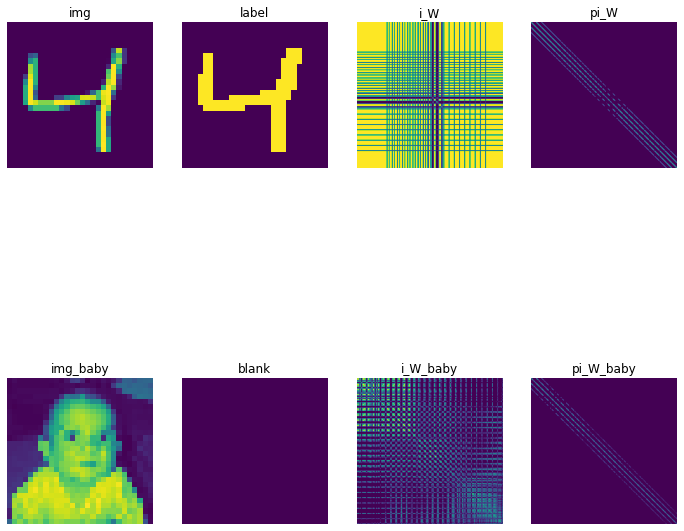

In [5]:
plt.rcParams["figure.figsize"] = (12,12) # specify the size for this cell
plot_images([weight for weight in weights.values()], 
            [key for key in weights.keys()],
            colmns=4)

In [6]:
# to store multiple different methods
from functools import partial

# the methods to store
import scipy.linalg as linalg
import scipy.sparse.linalg as sparse_linalg

def deterministic_vector_sign_flip(u):
    # from https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/utils/extmath.py#L1097
    max_abs_rows = np.argmax(np.abs(u))
    signs = np.sign(u[max_abs_rows])
    u *= signs
    return u

def shift_invert(input, func):
    input = input * -1
    return func(input)

# np.random.seed(0)

# Ordered dict to iterate over
eigs_options = OrderedDict(
    eigh_cff = partial(linalg.eigh, check_finite=False),
)

def setdiag(m,d):
    step = len(d) + 1
    m.flat[::step] = d

# non symm laplacian
def non_symm(W):
    # Diagonal Matrix - D
    d = np.sum(W, axis=1)
    D = np.zeros_like(W)
    np.fill_diagonal(D, d)

    A = D - W
    return A

# symm laplacian 2
def symm2(W):
    L = W + W.T # ensure symmetric
    np.fill_diagonal(L,0)
    D = L.sum(0) # symmetric so axis doesn't matter
    isolated_mask = (D == 0)
    D = np.where(isolated_mask, 1, np.sqrt(D))
    L = L/D
    L = L/D[:, np.newaxis]
    L = L * -1
    setdiag(L, 1 - isolated_mask)
    return L

laplace_options = OrderedDict(
    # non_symm = non_symm,
    symm2 = symm2
)

In [7]:
from tqdm import tqdm
    
# solve with any given eigensolver and laplacian approach
def generic_solve(W, laplace,solver):
    L = laplace(np.copy(W))
    _, eig_vectors = solver(L)
    
    output = eig_vectors[:, 1]
    deterministic_vector_sign_flip(output)
    output = output.reshape(28,28) 
    return output

outputs = []
errors = []

row_headers = []
col_headers = []
titles = []

for laplace_name, laplace_func in laplace_options.items(): # and each laplacian type
    if laplace_name not in titles:
        titles.append(laplace_name)
    
    sub_output = []
    for eig_name, eig_func in eigs_options.items(): # for each eigensolver    
        row_headers.append(eig_name)
        
        for weight_name, weight in (pbar := tqdm(weights.items())): # and each weight    
            pbar.set_description(f'{eig_name} - {laplace_name}')
            
            if weight_name not in ['img','img_baby', 'label', 'blank']: # that isn't some other array      
                if weight_name not in col_headers:
                    col_headers.append(weight_name)
                try:
                    out1 = generic_solve(weight, laplace_func, eig_func)
                    sub_output.append(out1) # solve and append its output
                except Exception as err:
                    sub_output.append(np.zeros_like(img))
                    errors.append(f'{eig_name} - {weight_name}\n{err=}\n')
    outputs.append(sub_output)

eigh_cff - symm2: 100%|██████████| 8/8 [00:00<00:00,  9.27it/s]


intensity, positonal * intensity


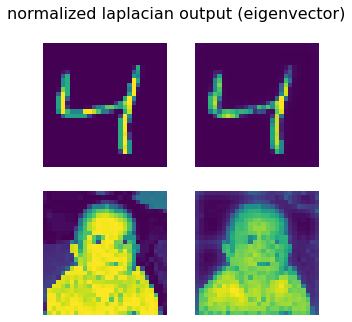

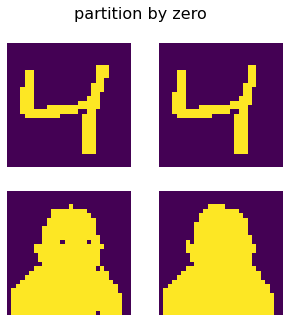

In [8]:
plt.rcParams["figure.figsize"] = (5,5) # specify the size for this cell

print('intensity, positonal * intensity')
for i in range(len(outputs)):
    plot_images(outputs[i],colmns=len(col_headers)//2, title='normalized laplacian output (eigenvector)') # row_headers=row_headers, col_headers=col_headers,
    plot_images([partition_by_zero(output) for output in outputs[i]], title='partition by zero')

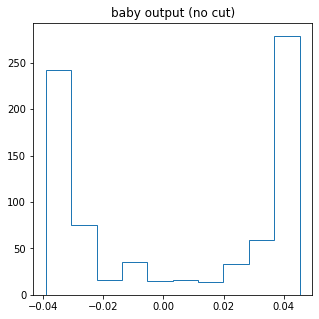

[242  75  16  35  15  16  14  33  59 279]
[-0.03897042 -0.03054983 -0.02212923 -0.01370863 -0.00528804  0.00313256
  0.01155316  0.01997375  0.02839435  0.03681495  0.04523554]


In [9]:
plt.rcParams["figure.figsize"] = (5,5) # specify the size for this cell

# counts, bins = np.histogram(img_baby)
# plt.stairs(counts,bins)
# plt.title('baby input')
# plt.show()
# print(counts)
# print(bins)

counts, bins = np.histogram(outputs[0][2])
plt.stairs(counts,bins)
plt.title('baby output (no cut)')
plt.show()
print(counts)
print(bins)

In [10]:
# Now, test a loss function as the outputs go
import torch
import torch.nn as nn


# criterion = lech_loss

# random_count = 3
steps = 10
lerp_weight = 0.05
criterion = nn.HingeEmbeddingLoss()

losses = []

W_true = intens_posit_wm(img_baby).astype(float)
true = outputs[0][3].astype(float)

W_rand = np.random.randn(*W_true.shape).astype(float)

W_rand_symm = np.tril(W_rand) + np.tril(W_rand, -1).T
in_between_symm = W_rand_symm

outs = []
weights = []
for i in range(0, steps+1):
    in_between_symm = torch.lerp(torch.tensor(in_between_symm), torch.tensor((W_true + W_true.T)/2), lerp_weight).numpy()
    in_between_symm = (in_between_symm + in_between_symm.T) / 2
    
    if i == steps:
        in_between_symm = W_true
        
    weights.append(in_between_symm)
    
    #TODO: add noise or otherwise
    
    # pred = generic_solve(in_between_symm, symm2, partial(linalg.eigh, check_finite=False))
    # outs.append(pred)
    
    # loss = ...
    # losses.append(loss.item())
    
    
plot_images(weights)
    
# x = np.linspace(0, steps, steps)
# plt.plot(x, losses)
# plt.show()